# Semi-supervised Learning

Semi-supervised learning is a situation in which in your training data some of the samples are not labeled. The semi-supervised estimators in sklearn.semi_supervised are able to make use of this additional unlabeled data to better capture the shape of the underlying data distribution and generalize better to new samples. These algorithms can perform well when we have a very small amount of labeled points and a large amount of unlabeled points.

## Unlabeled entries in y

It is important to assign an identifier to unlabeled points along with the labeled data when training the model with the fit method. The identifier that this implementation uses is the integer value. Note that for string labels, the dtype of y should be object so that it can contain both strings and integers.

## Self Training

This self-training implementation is based on Yarowsky’s [1] algorithm. Using this algorithm, a given supervised classifier can function as a semi-supervised classifier, allowing it to learn from unlabeled data.

SelfTrainingClassifier can be called with any classifier that implements predict_proba, passed as the parameter base_classifier. In each iteration, the base_classifier predicts labels for the unlabeled samples and adds a subset of these labels to the labeled dataset.

The choice of this subset is determined by the selection criterion. This selection can be done using a threshold on the prediction probabilities, or by choosing the k_best samples according to the prediction probabilities.

The labels used for the final fit as well as the iteration in which each sample was labeled are available as attributes. The optional max_iter parameter specifies how many times the loop is executed at most.

The max_iter parameter may be set to None, causing the algorithm to iterate until all samples have labels or no new samples are selected in that iteration.

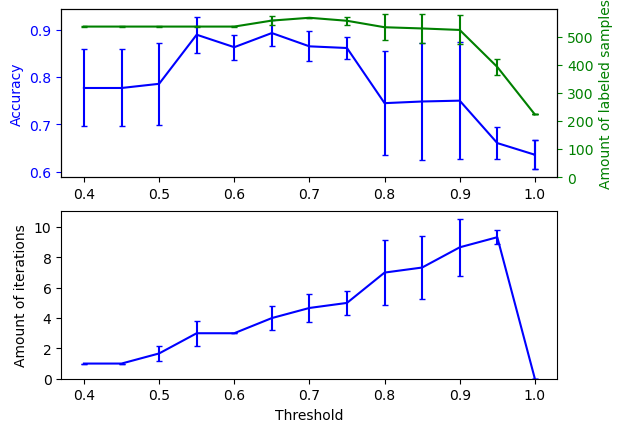

In [1]:
# Effect of varying threshold for self-training

# Authors: Oliver Rausch <rauscho@ethz.ch>
# License: BSD

import matplotlib.pyplot as plt
import numpy as np

from sklearn import datasets
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.svm import SVC
from sklearn.utils import shuffle

n_splits = 3

X, y = datasets.load_breast_cancer(return_X_y=True)
X, y = shuffle(X, y, random_state=42)
y_true = y.copy()
y[50:] = -1
total_samples = y.shape[0]

base_classifier = SVC(probability=True, gamma=0.001, random_state=42)

x_values = np.arange(0.4, 1.05, 0.05)
x_values = np.append(x_values, 0.99999)
scores = np.empty((x_values.shape[0], n_splits))
amount_labeled = np.empty((x_values.shape[0], n_splits))
amount_iterations = np.empty((x_values.shape[0], n_splits))

for i, threshold in enumerate(x_values):
    self_training_clf = SelfTrainingClassifier(base_classifier, threshold=threshold)

    # We need manual cross validation so that we don't treat -1 as a separate
    # class when computing accuracy
    skfolds = StratifiedKFold(n_splits=n_splits)
    for fold, (train_index, test_index) in enumerate(skfolds.split(X, y)):
        X_train = X[train_index]
        y_train = y[train_index]
        X_test = X[test_index]
        y_test = y[test_index]
        y_test_true = y_true[test_index]

        self_training_clf.fit(X_train, y_train)

        # The amount of labeled samples that at the end of fitting
        amount_labeled[i, fold] = (
            total_samples
            - np.unique(self_training_clf.labeled_iter_, return_counts=True)[1][0]
        )
        # The last iteration the classifier labeled a sample in
        amount_iterations[i, fold] = np.max(self_training_clf.labeled_iter_)

        y_pred = self_training_clf.predict(X_test)
        scores[i, fold] = accuracy_score(y_test_true, y_pred)


ax1 = plt.subplot(211)
ax1.errorbar(
    x_values, scores.mean(axis=1), yerr=scores.std(axis=1), capsize=2, color="b"
)
ax1.set_ylabel("Accuracy", color="b")
ax1.tick_params("y", colors="b")

ax2 = ax1.twinx()
ax2.errorbar(
    x_values,
    amount_labeled.mean(axis=1),
    yerr=amount_labeled.std(axis=1),
    capsize=2,
    color="g",
)
ax2.set_ylim(bottom=0)
ax2.set_ylabel("Amount of labeled samples", color="g")
ax2.tick_params("y", colors="g")

ax3 = plt.subplot(212, sharex=ax1)
ax3.errorbar(
    x_values,
    amount_iterations.mean(axis=1),
    yerr=amount_iterations.std(axis=1),
    capsize=2,
    color="b",
)
ax3.set_ylim(bottom=0)
ax3.set_ylabel("Amount of iterations")
ax3.set_xlabel("Threshold")

plt.show()

## Label Propagation

Label propagation denotes a few variations of semi-supervised graph inference algorithms.

A few features available in this model:

- Used for classification tasks
- Kernel methods to project data into alternate dimensional spaces

scikit-learn provides two label propagation models: LabelPropagation and LabelSpreading. Both work by constructing a similarity graph over all items in the input dataset.

- LabelPropagation
  - Change the weight of the true ground labeled data to some degree.
    
    algorithm performs hard clamping of input labels, which means $\alpha=0$. This clamping factor can be relaxed, to say $\alpha=0.2$, which means that we will always retain 80 percent of our original label distribution, but the algorithm gets to change its confidence of the distribution within 20 percent.

- LabelSpreading
  - Minimizes a loss function that has regularization properties, as such it is often more robust to noise. The algorithm iterates on a modified version of the original graph and normalizes the edge weights by computing the normalized graph Laplacian matrix. This procedure is also used in Spectral clustering.

- Kernel Function
  - RBF
  - KNN

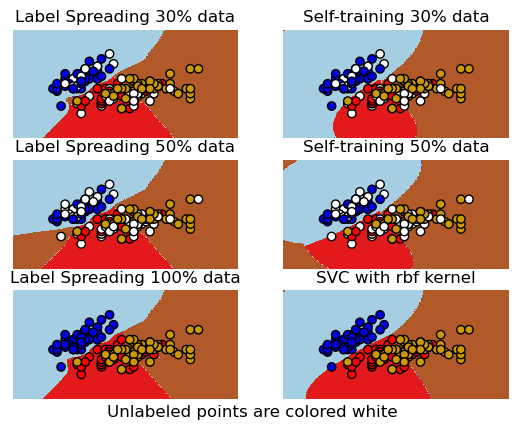

In [3]:
# Decision boundary of semi-supervised classifiers versus SVM on the Iris dataset

# Authors: Clay Woolam   <clay@woolam.org>
#          Oliver Rausch <rauscho@ethz.ch>
# License: BSD

import matplotlib.pyplot as plt
import numpy as np

from sklearn import datasets
from sklearn.semi_supervised import LabelSpreading, SelfTrainingClassifier
from sklearn.svm import SVC

iris = datasets.load_iris()

X = iris.data[:, :2]
y = iris.target

# step size in the mesh
h = 0.02

rng = np.random.RandomState(0)
y_rand = rng.rand(y.shape[0])
y_30 = np.copy(y)
y_30[y_rand < 0.3] = -1  # set random samples to be unlabeled
y_50 = np.copy(y)
y_50[y_rand < 0.5] = -1
# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
ls30 = (LabelSpreading().fit(X, y_30), y_30, "Label Spreading 30% data")
ls50 = (LabelSpreading().fit(X, y_50), y_50, "Label Spreading 50% data")
ls100 = (LabelSpreading().fit(X, y), y, "Label Spreading 100% data")

# the base classifier for self-training is identical to the SVC
base_classifier = SVC(kernel="rbf", gamma=0.5, probability=True)
st30 = (
    SelfTrainingClassifier(base_classifier).fit(X, y_30),
    y_30,
    "Self-training 30% data",
)
st50 = (
    SelfTrainingClassifier(base_classifier).fit(X, y_50),
    y_50,
    "Self-training 50% data",
)

rbf_svc = (SVC(kernel="rbf", gamma=0.5).fit(X, y), y, "SVC with rbf kernel")

# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

color_map = {-1: (1, 1, 1), 0: (0, 0, 0.9), 1: (1, 0, 0), 2: (0.8, 0.6, 0)}

classifiers = (ls30, st30, ls50, st50, ls100, rbf_svc)
for i, (clf, y_train, title) in enumerate(classifiers):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    plt.subplot(3, 2, i + 1)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
    plt.axis("off")

    # Plot also the training points
    colors = [color_map[y] for y in y_train]
    plt.scatter(X[:, 0], X[:, 1], c=colors, edgecolors="black")

    plt.title(title)

plt.suptitle("Unlabeled points are colored white", y=0.1)
plt.show()

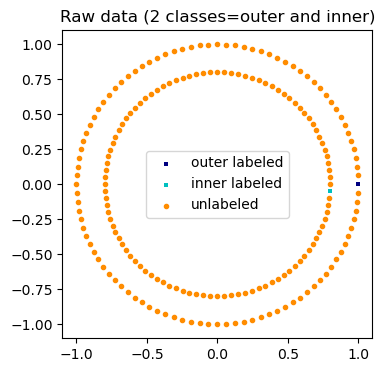

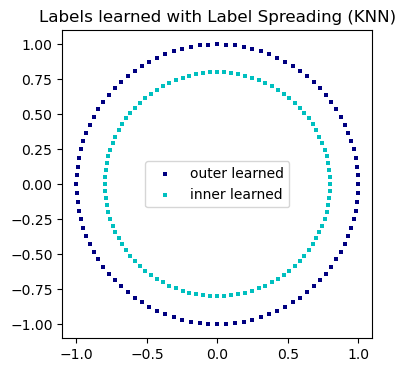

In [5]:
import numpy as np

from sklearn.datasets import make_circles

n_samples = 200
X, y = make_circles(n_samples=n_samples, shuffle=False)
outer, inner = 0, 1
labels = np.full(n_samples, -1.0)
labels[0] = outer
labels[-1] = inner

import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
plt.scatter(
    X[labels == outer, 0],
    X[labels == outer, 1],
    color="navy",
    marker="s",
    lw=0,
    label="outer labeled",
    s=10,
)
plt.scatter(
    X[labels == inner, 0],
    X[labels == inner, 1],
    color="c",
    marker="s",
    lw=0,
    label="inner labeled",
    s=10,
)
plt.scatter(
    X[labels == -1, 0],
    X[labels == -1, 1],
    color="darkorange",
    marker=".",
    label="unlabeled",
)
plt.legend(scatterpoints=1, shadow=False, loc="center")
_ = plt.title("Raw data (2 classes=outer and inner)")

from sklearn.semi_supervised import LabelSpreading

label_spread = LabelSpreading(kernel="knn", alpha=0.8)
label_spread.fit(X, labels)

output_labels = label_spread.transduction_
output_label_array = np.asarray(output_labels)
outer_numbers = np.where(output_label_array == outer)[0]
inner_numbers = np.where(output_label_array == inner)[0]

plt.figure(figsize=(4, 4))
plt.scatter(
    X[outer_numbers, 0],
    X[outer_numbers, 1],
    color="navy",
    marker="s",
    lw=0,
    s=10,
    label="outer learned",
)
plt.scatter(
    X[inner_numbers, 0],
    X[inner_numbers, 1],
    color="c",
    marker="s",
    lw=0,
    s=10,
    label="inner learned",
)
plt.legend(scatterpoints=1, shadow=False, loc="center")
plt.title("Labels learned with Label Spreading (KNN)")
plt.show()

Label Spreading model: 40 labeled & 300 unlabeled points (340 total)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       0.82      1.00      0.90        37
           2       1.00      0.86      0.92        28
           3       1.00      0.80      0.89        35
           4       0.92      1.00      0.96        24
           5       0.74      0.94      0.83        34
           6       0.89      0.96      0.92        25
           7       0.94      0.89      0.91        35
           8       1.00      0.68      0.81        31
           9       0.81      0.88      0.84        24

    accuracy                           0.90       300
   macro avg       0.91      0.90      0.90       300
weighted avg       0.91      0.90      0.90       300



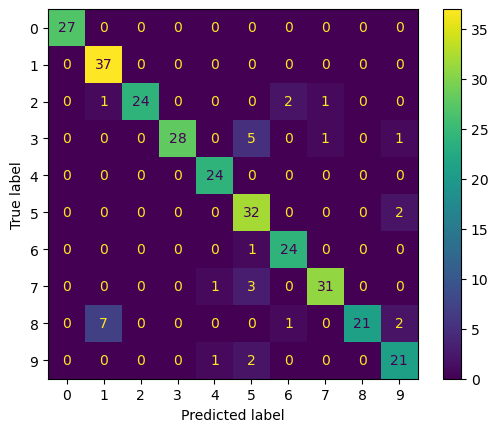

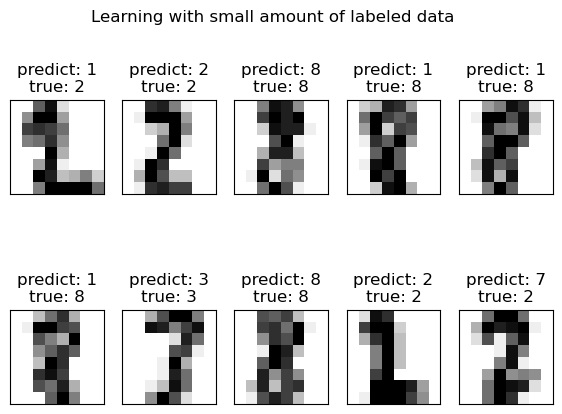

In [6]:
import numpy as np

from sklearn import datasets

digits = datasets.load_digits()
rng = np.random.RandomState(2)
indices = np.arange(len(digits.data))
rng.shuffle(indices)

X = digits.data[indices[:340]]
y = digits.target[indices[:340]]
images = digits.images[indices[:340]]

n_total_samples = len(y)
n_labeled_points = 40

indices = np.arange(n_total_samples)

unlabeled_set = indices[n_labeled_points:]

y_train = np.copy(y)
y_train[unlabeled_set] = -1

from sklearn.metrics import classification_report
from sklearn.semi_supervised import LabelSpreading

lp_model = LabelSpreading(gamma=0.25, max_iter=20)
lp_model.fit(X, y_train)
predicted_labels = lp_model.transduction_[unlabeled_set]
true_labels = y[unlabeled_set]

print(
    "Label Spreading model: %d labeled & %d unlabeled points (%d total)"
    % (n_labeled_points, n_total_samples - n_labeled_points, n_total_samples)
)

print(classification_report(true_labels, predicted_labels))

from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
    true_labels, predicted_labels, labels=lp_model.classes_
)

from scipy import stats

pred_entropies = stats.distributions.entropy(lp_model.label_distributions_.T)

uncertainty_index = np.argsort(pred_entropies)[-10:]

import matplotlib.pyplot as plt

f = plt.figure(figsize=(7, 5))
for index, image_index in enumerate(uncertainty_index):
    image = images[image_index]

    sub = f.add_subplot(2, 5, index + 1)
    sub.imshow(image, cmap=plt.cm.gray_r)
    plt.xticks([])
    plt.yticks([])
    sub.set_title(
        "predict: %i\ntrue: %i" % (lp_model.transduction_[image_index], y[image_index])
    )

f.suptitle("Learning with small amount of labeled data")
plt.show()